In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

2024-01-20 21:13:29.022749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [4]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')

(array([2.8238e+04, 1.0214e+04, 3.5510e+03, 1.2260e+03, 4.4100e+02,
        9.7000e+01, 1.5000e+01, 7.0000e+00, 8.0000e+00, 3.0000e+00]),
 array([  0. ,  99.4, 198.8, 298.2, 397.6, 497. , 596.4, 695.8, 795.2,
        894.6, 994. ]),
 <BarContainer object of 10 artists>)

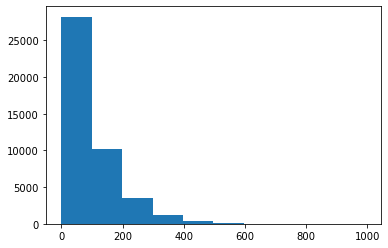

In [5]:
plt.hist(data['pollution'])

### Preprocess

In [6]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [7]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [8]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### PM threshold

In [9]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(30601,)
(6558,)
(6558,)


In [10]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.33400402414486924


### train_X_filter

In [11]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(848, 72, 11)
(848, 12)


In [12]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(29753, 72, 11)
(29753, 12)


### val_X_filter

In [13]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(752, 72, 11)
(752, 12)


In [14]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(5806, 72, 11)
(5806, 12)


### test_X_filter

In [15]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(581, 72, 11)
(581, 12)


In [16]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(5977, 72, 11)
(5977, 12)


### Model

In [18]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 50
EPOCHS = 500
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [33]:
# trained_cnn = load_model('../../saved_models/pm_all.h5')
# trained_cnn = load_model('../../saved_models/pm_all_weighted_IPF_95.h5')
# trained_cnn = load_model('../../saved_models/pm_all_weighted_EVT_95.h5') 
trained_cnn = load_model('../../saved_models/pm_all_weighted_META.h5')

freeze_layer_index = 17

for i, layer in enumerate(trained_cnn.layers):
    #print(i, layer)
    if i <= freeze_layer_index:
        layer.trainable = False


l2_strength = 1e-8
for i in range(freeze_layer_index+1, len(trained_cnn.layers)):
    trained_cnn.layers[i].kernel_regularizer = l2(l2_strength)


trained_cnn._name = 'all_95_ft'
# trained_cnn.summary()

In [318]:
trained_cnn.compile(optimizer='adam',
                    loss='mse',
                    metrics=['mae']
                   )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint(
                     '../../saved_models/pm_all_weighted_META_ft.h5', 
#                      '../../saved_models/pm_all_weighted_EVT_95_ft.h5', 
#                      '../../saved_models/pm_all_weighted_IPF_95_ft.h5', 
#                      '../../saved_models/pm_all_95_ft.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


trained_cnn.fit(train_X_extreme, train_y_extreme,
                validation_data=(val_X_extreme, val_y_extreme),
                epochs=EPOCHS,
                batch_size=BATCH,
                verbose=2,
                shuffle=True,
                callbacks=[es, mc]
               )

Epoch 1/500
2/2 - 1s - loss: 0.0058 - mae: 0.0488 - val_loss: 0.0102 - val_mae: 0.0670

Epoch 00001: val_mae improved from inf to 0.06695, saving model to ../../saved_models/pm_all_weighted_META_ft2.h5
Epoch 2/500
2/2 - 0s - loss: 0.0054 - mae: 0.0468 - val_loss: 0.0106 - val_mae: 0.0696

Epoch 00002: val_mae did not improve from 0.06695
Epoch 3/500
2/2 - 0s - loss: 0.0055 - mae: 0.0484 - val_loss: 0.0101 - val_mae: 0.0670

Epoch 00003: val_mae did not improve from 0.06695
Epoch 4/500
2/2 - 0s - loss: 0.0052 - mae: 0.0461 - val_loss: 0.0102 - val_mae: 0.0678

Epoch 00004: val_mae did not improve from 0.06695
Epoch 5/500
2/2 - 0s - loss: 0.0052 - mae: 0.0470 - val_loss: 0.0101 - val_mae: 0.0673

Epoch 00005: val_mae did not improve from 0.06695
Epoch 6/500
2/2 - 0s - loss: 0.0050 - mae: 0.0458 - val_loss: 0.0100 - val_mae: 0.0666

Epoch 00006: val_mae improved from 0.06695 to 0.06655, saving model to ../../saved_models/pm_all_weighted_META_ft2.h5
Epoch 7/500
2/2 - 0s - loss: 0.0050 - ma


Epoch 00058: val_mae did not improve from 0.06642
Epoch 59/500
2/2 - 0s - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0110 - val_mae: 0.0715

Epoch 00059: val_mae did not improve from 0.06642
Epoch 60/500
2/2 - 0s - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0111 - val_mae: 0.0717

Epoch 00060: val_mae did not improve from 0.06642
Epoch 61/500
2/2 - 0s - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0109 - val_mae: 0.0707

Epoch 00061: val_mae did not improve from 0.06642
Epoch 62/500
2/2 - 0s - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0111 - val_mae: 0.0717

Epoch 00062: val_mae did not improve from 0.06642
Epoch 63/500
2/2 - 0s - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0110 - val_mae: 0.0713

Epoch 00063: val_mae did not improve from 0.06642
Epoch 64/500
2/2 - 0s - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0110 - val_mae: 0.0712

Epoch 00064: val_mae did not improve from 0.06642
Epoch 65/500
2/2 - 0s - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0111 - val_mae: 0.0719

Epoch 00065: val_mae did n


Epoch 00117: val_mae did not improve from 0.06642
Epoch 118/500
2/2 - 0s - loss: 0.0023 - mae: 0.0340 - val_loss: 0.0121 - val_mae: 0.0763

Epoch 00118: val_mae did not improve from 0.06642
Epoch 119/500
2/2 - 0s - loss: 0.0023 - mae: 0.0339 - val_loss: 0.0120 - val_mae: 0.0759

Epoch 00119: val_mae did not improve from 0.06642
Epoch 120/500
2/2 - 0s - loss: 0.0023 - mae: 0.0338 - val_loss: 0.0121 - val_mae: 0.0763

Epoch 00120: val_mae did not improve from 0.06642
Epoch 121/500
2/2 - 0s - loss: 0.0023 - mae: 0.0338 - val_loss: 0.0122 - val_mae: 0.0768

Epoch 00121: val_mae did not improve from 0.06642
Epoch 122/500
2/2 - 0s - loss: 0.0022 - mae: 0.0337 - val_loss: 0.0122 - val_mae: 0.0766

Epoch 00122: val_mae did not improve from 0.06642
Epoch 123/500
2/2 - 0s - loss: 0.0022 - mae: 0.0336 - val_loss: 0.0123 - val_mae: 0.0770

Epoch 00123: val_mae did not improve from 0.06642
Epoch 124/500
2/2 - 0s - loss: 0.0022 - mae: 0.0335 - val_loss: 0.0122 - val_mae: 0.0764

Epoch 00124: val_ma


Epoch 00176: val_mae did not improve from 0.06642
Epoch 177/500
2/2 - 0s - loss: 0.0018 - mae: 0.0310 - val_loss: 0.0131 - val_mae: 0.0798

Epoch 00177: val_mae did not improve from 0.06642
Epoch 178/500
2/2 - 0s - loss: 0.0018 - mae: 0.0309 - val_loss: 0.0131 - val_mae: 0.0800

Epoch 00178: val_mae did not improve from 0.06642
Epoch 179/500
2/2 - 0s - loss: 0.0018 - mae: 0.0309 - val_loss: 0.0130 - val_mae: 0.0796

Epoch 00179: val_mae did not improve from 0.06642
Epoch 180/500
2/2 - 0s - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0130 - val_mae: 0.0796

Epoch 00180: val_mae did not improve from 0.06642
Epoch 181/500
2/2 - 0s - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0131 - val_mae: 0.0800

Epoch 00181: val_mae did not improve from 0.06642
Epoch 182/500
2/2 - 0s - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0130 - val_mae: 0.0794

Epoch 00182: val_mae did not improve from 0.06642
Epoch 183/500
2/2 - 0s - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0133 - val_mae: 0.0805

Epoch 00183: val_ma